In [2]:
%matplotlib inline
#%matplotlib notebook

In [3]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

In [4]:
inputs = [
    ["Experiment_Tube_001_001.fcs",1e-12, 0],
    ["Experiment_Tube_002_002.fcs",1e-10, 0],
    ["Experiment_Tube_003_003.fcs",1e-8, 0],
    ["Experiment_Tube_004_004.fcs",1e-6, 0],
    ["Experiment_Tube_005_005.fcs",1e-4, 0],
    ["Experiment_Tube_006_006.fcs",1e-12, 2e-4],
    ["Experiment_Tube_007_007.fcs",1e-10, 2e-4],
    ["Experiment_Tube_008_008.fcs",1e-8, 2e-4],
    ["Experiment_Tube_009_009.fcs",1e-6, 2e-4],
    ["Experiment_Tube_010_010.fcs",1e-4, 2e-4],
    ["Experiment_Tube_011_011.fcs",1e-12, 1e-3],
    ["Experiment_Tube_012_012.fcs",1e-10, 1e-3],
    ["Experiment_Tube_013_013.fcs",1e-8, 1e-3],
    ["Experiment_Tube_014_014.fcs",1e-6, 1e-3],
    ["Experiment_Tube_015_015.fcs",1e-4, 1e-3],
]
in2 = [["Experiment_Tube_016_016.fcs",1e-4, 2e-4,1,30],
       ["Experiment_Tube_017_017.fcs",1e-4, 1e-3,1,30],
       ["Experiment_Tube_018_018.fcs",1e-6, 1e-3,1,30],
       ["Experiment_Tube_019_019.fcs",1e-4, 1e-3,2,20],
       ["Experiment_Tube_010_010.fcs",1e-4, 2e-4,2,30],
       ["Experiment_Tube_014_014.fcs",1e-6, 1e-3,2,30],
       ["Experiment_Tube_015_015.fcs",1e-4, 1e-3,2,30]
]
       
tubes = []
for filename, ahl, iptg in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float'},
                   tubes = tubes).apply()
       
tubes2 = []
for filename, ahl, iptg, pfa, time in in2:
    tubes2.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg, 'PFA' : pfa, 'Minutes' : time}))
    
ex2 = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float', 'PFA' : 'int', 'Minutes' : 'int'},
                   tubes = tubes2).apply()

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


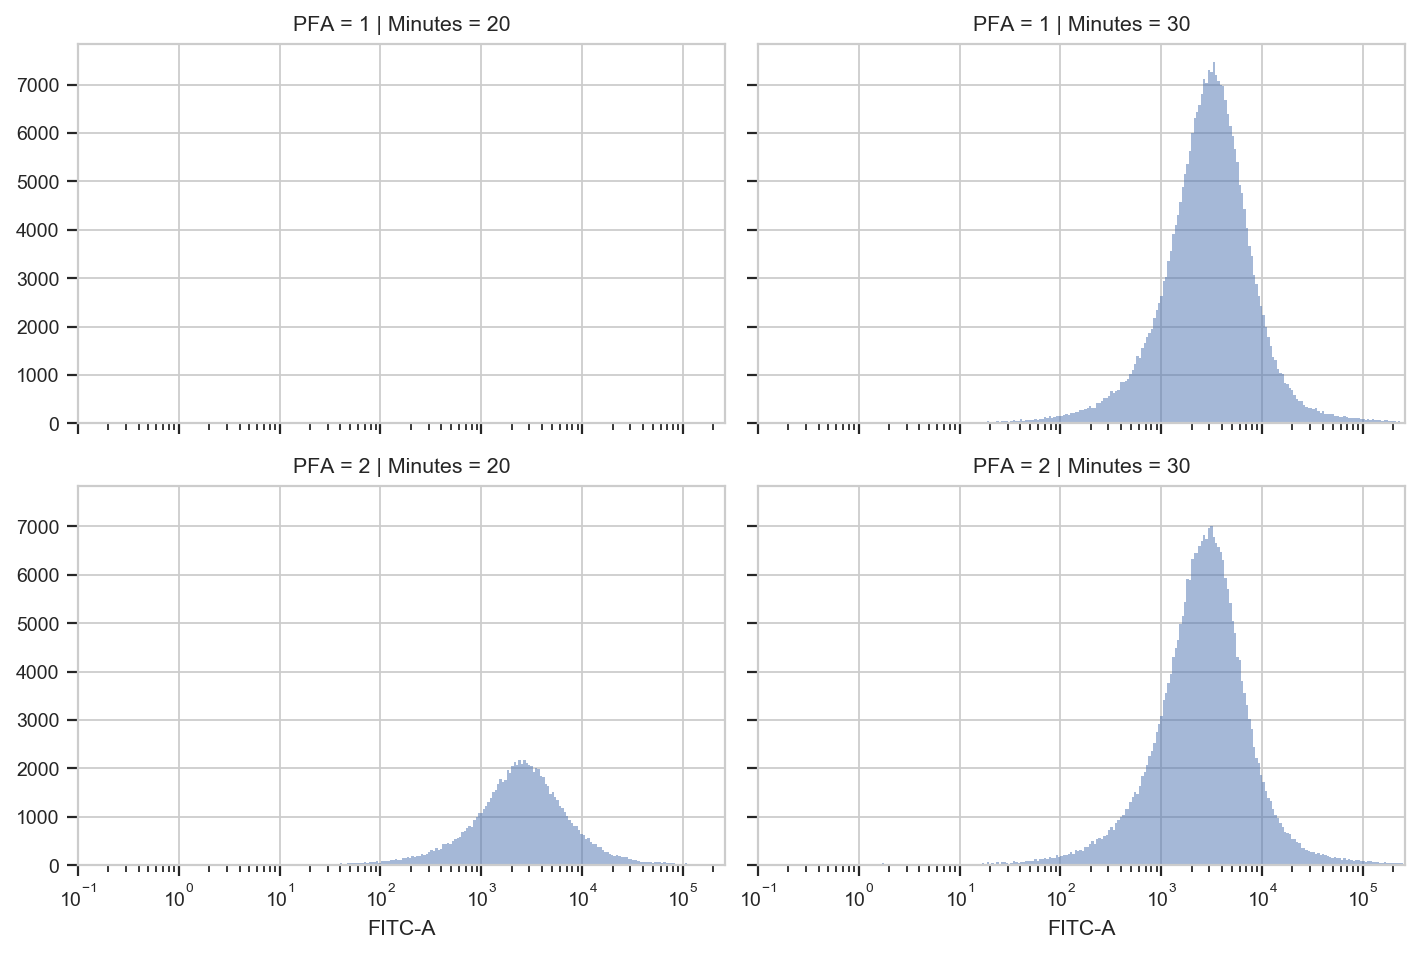

In [5]:
flow.HistogramView(channel = "FITC-A",
                   xfacet = "Minutes",
                   yfacet = "PFA",
                   scale='log').plot(ex2)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


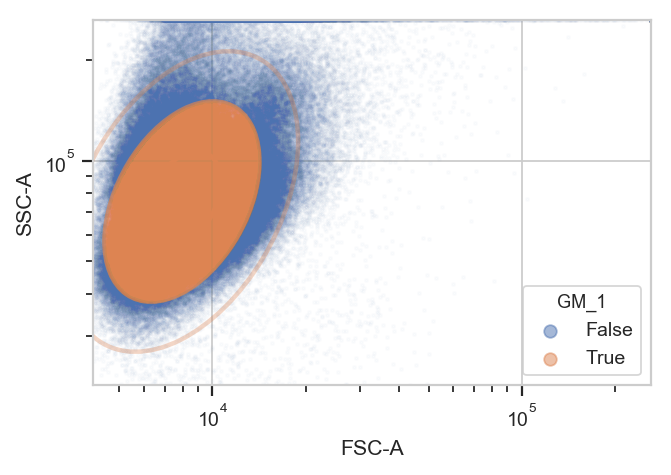

In [6]:
gm2 = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm2.estimate(ex2)
ex_gm2 = gm2.apply(ex2)
gm2.default_view().plot(ex_gm2, alpha = 0.02)

## Effect of fixation time on mNG intensity

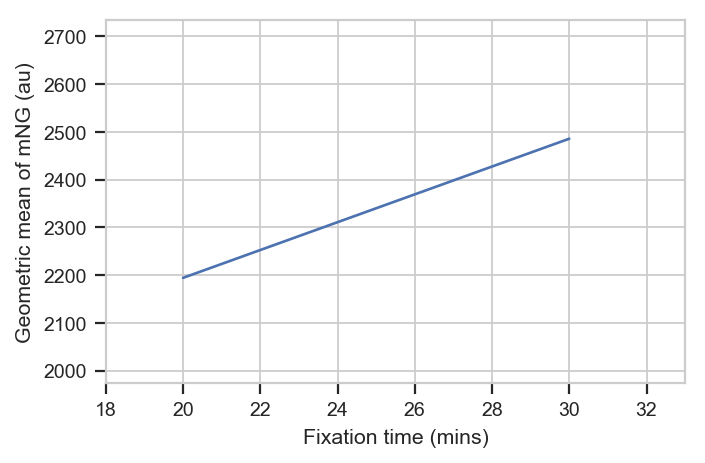

In [7]:
ex3 = flow.ChannelStatisticOp(name = "ByMins",
                              channel = "FITC-A",
                              by = ["Minutes"],
                              function = flow.geom_mean).apply(ex_gm2)
flow.Stats1DView(statistic = ("ByMins", "geom_mean"),
                 scale = "linear",
                 variable = "Minutes",
                 variable_scale = "linear").plot(ex3,ylabel = 'Geometric mean of mNG (au)',xlabel ='Fixation time (mins)')

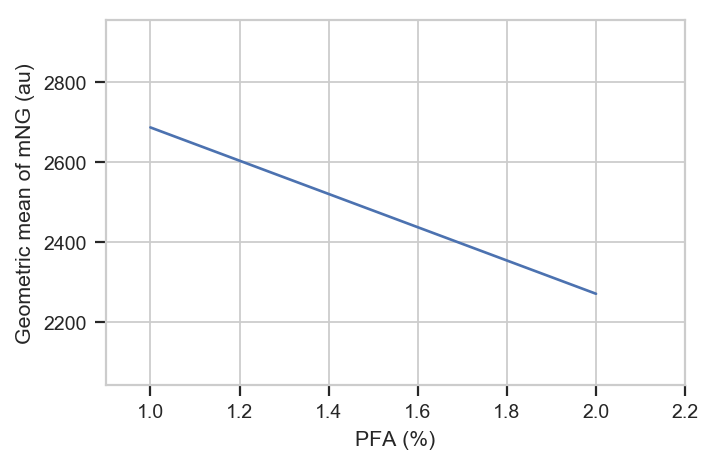

In [8]:
ex3 = flow.ChannelStatisticOp(name = "ByPFA",
                              channel = "FITC-A",
                              by = ["PFA"],
                              function = flow.geom_mean).apply(ex_gm2)
flow.Stats1DView(statistic = ("ByPFA", "geom_mean"),
                 scale = "linear",
                 variable = "PFA",
                 variable_scale = "linear").plot(ex3,ylabel = 'Geometric mean of mNG (au)',xlabel ='PFA (%)')

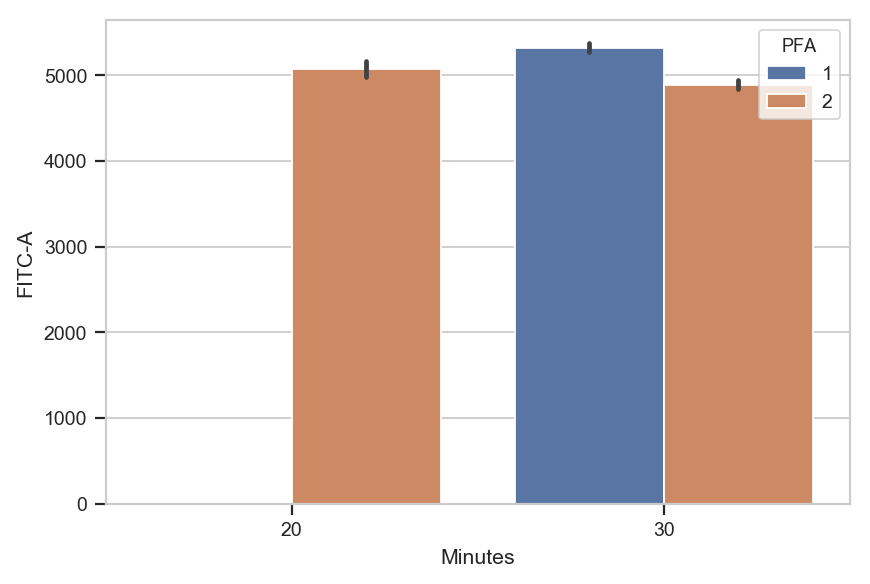

In [9]:
df = ex_gm2.data
sns.barplot(x='Minutes', y='FITC-A',hue='PFA',data=df)

In [10]:
flow.set_default_scale("log")

# Plot FITC-A histograms for all IPTG and AHL induction conditions

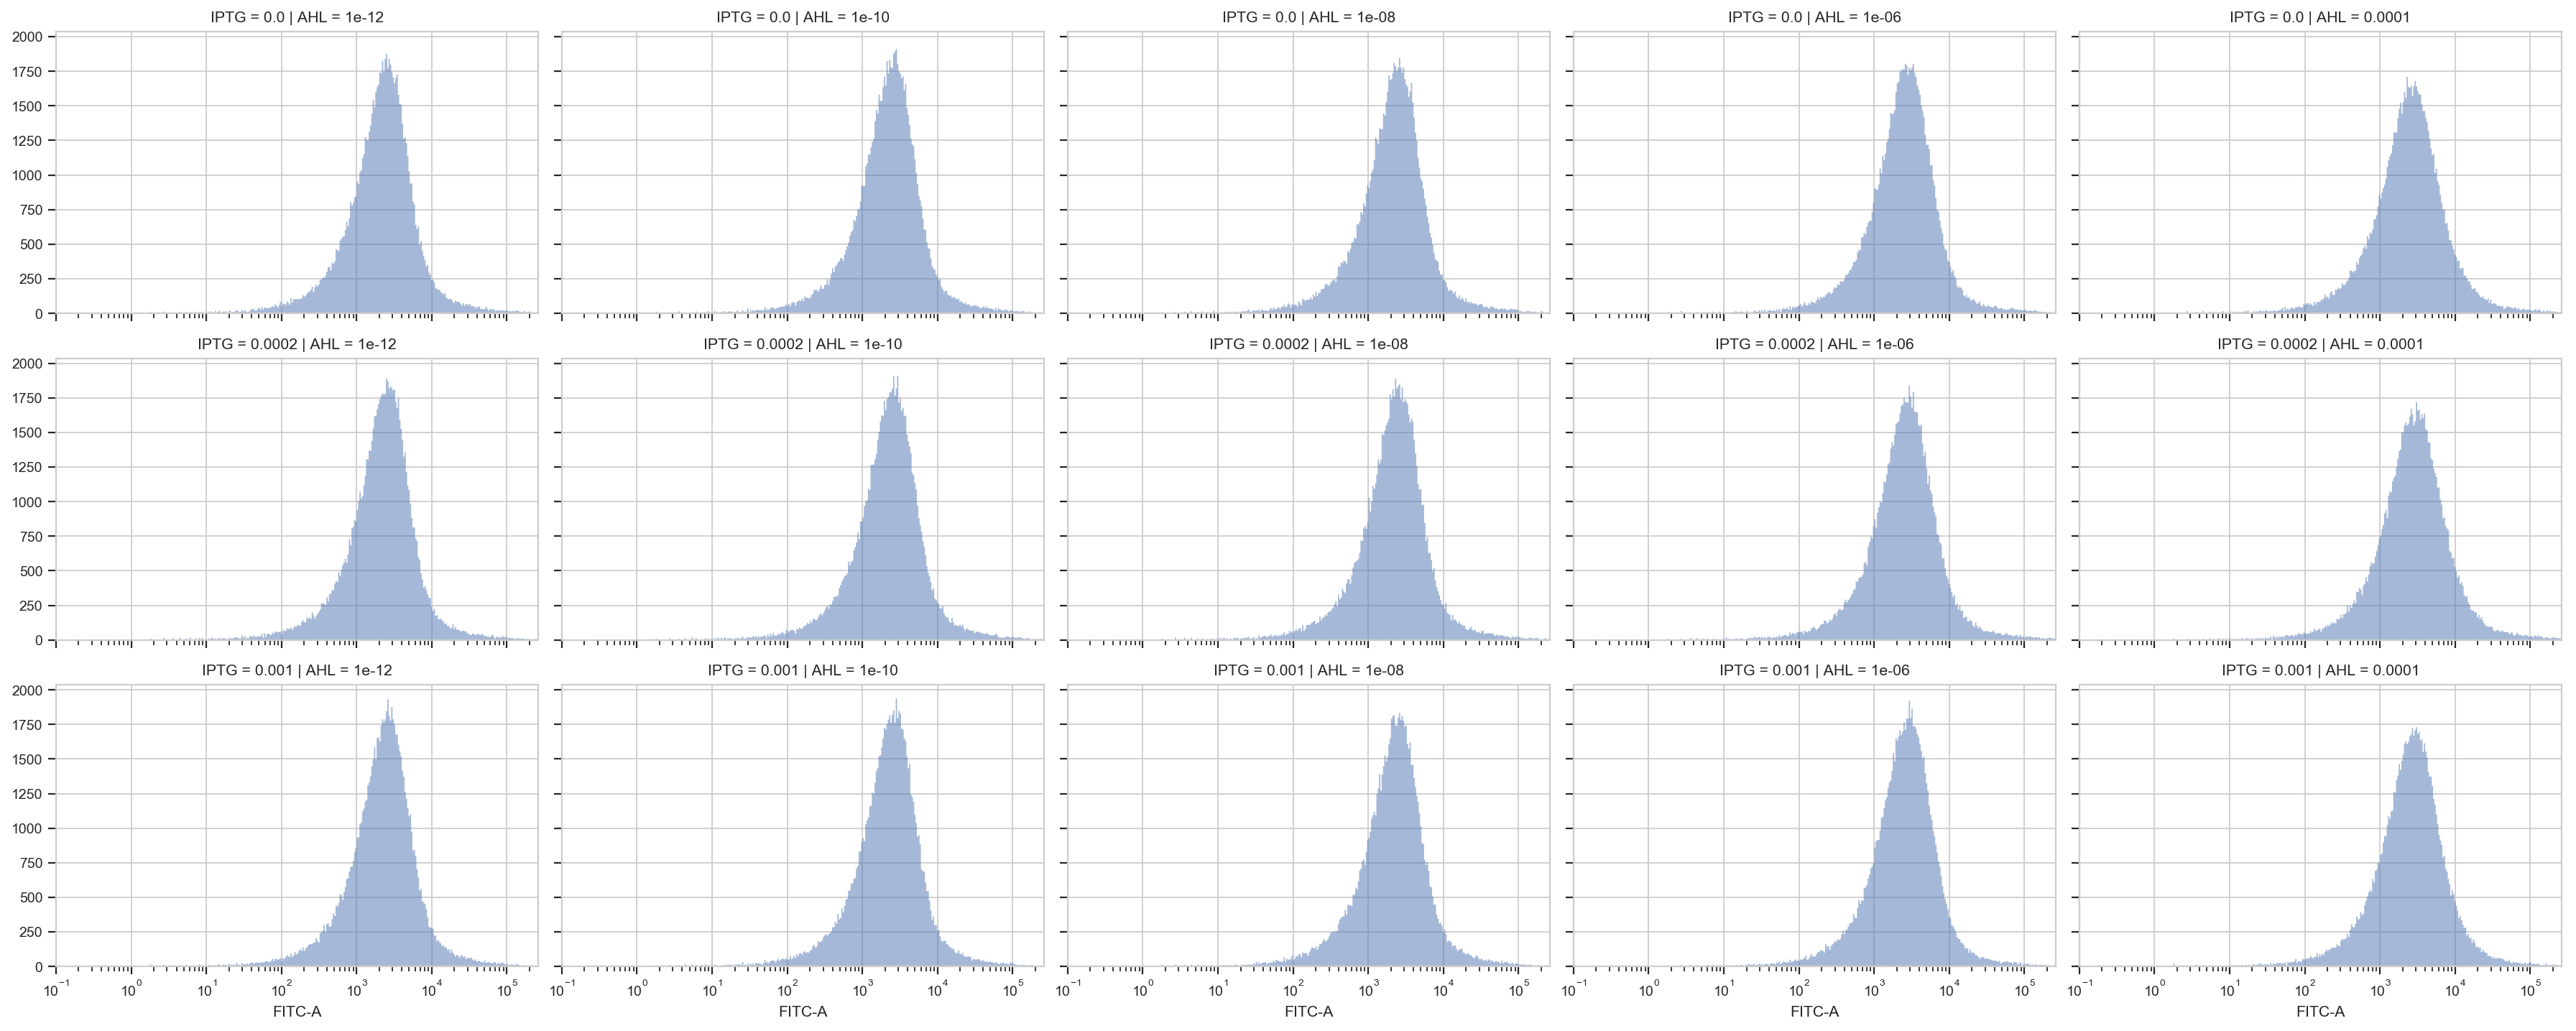

In [11]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

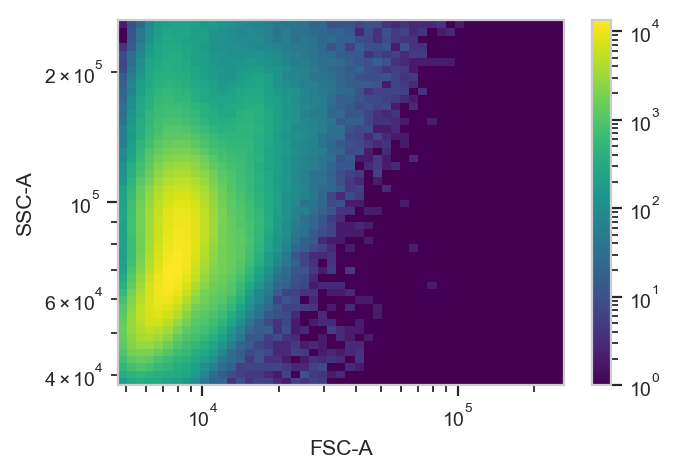

In [12]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

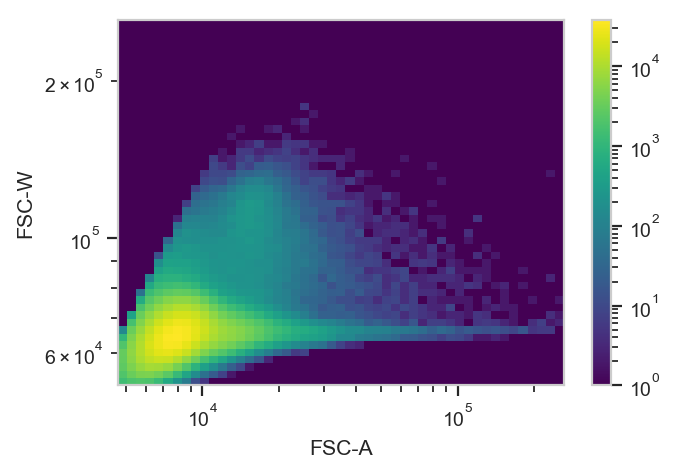

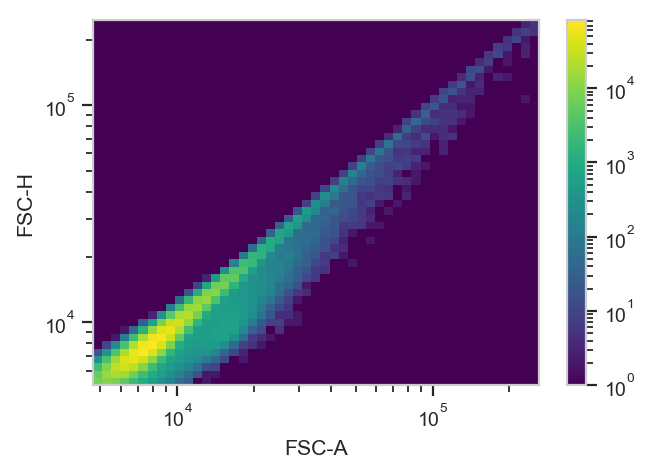

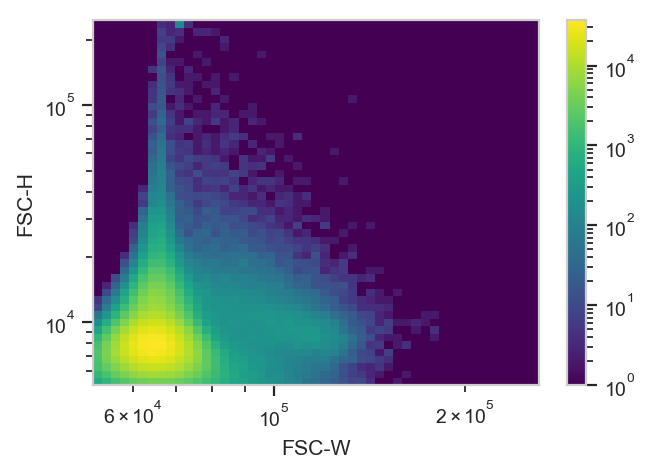

In [13]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


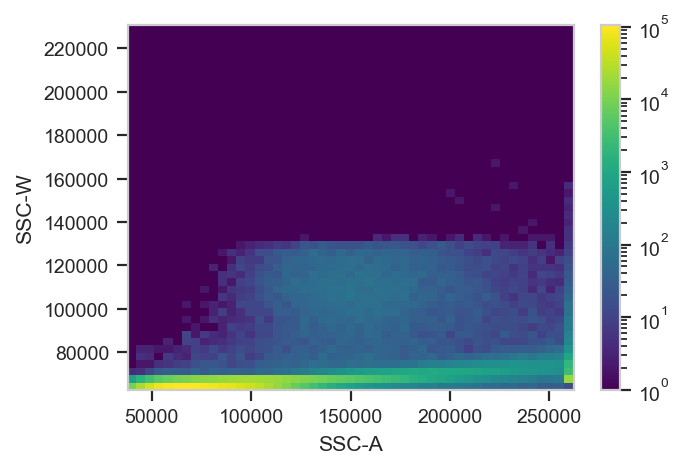

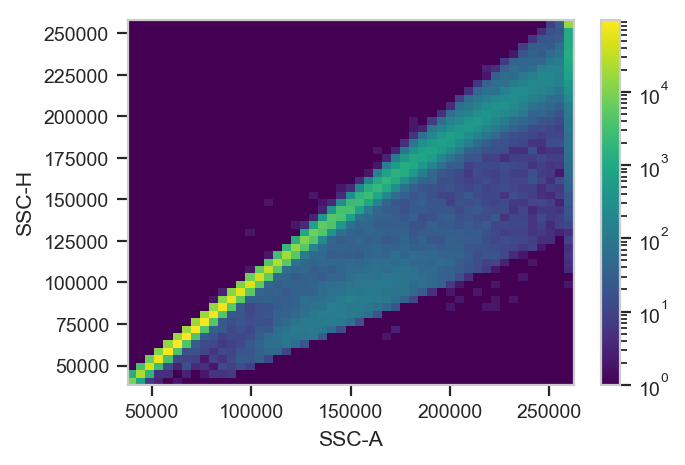

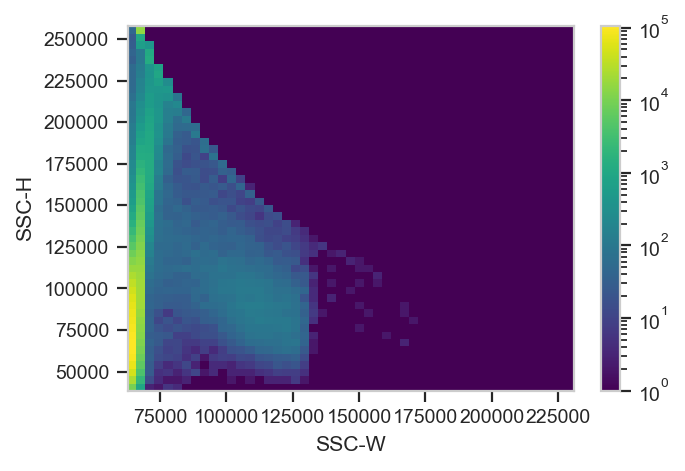

In [14]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

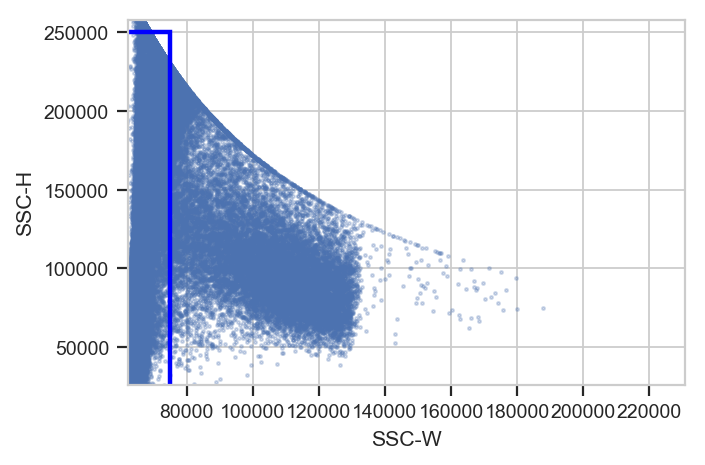

In [15]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 75000,
                   ychannel = "SSC-H",
                   ylow = 5000,
                   yhigh = 250000)
                   
rv = r.default_view(xscale ='linear',yscale='linear')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


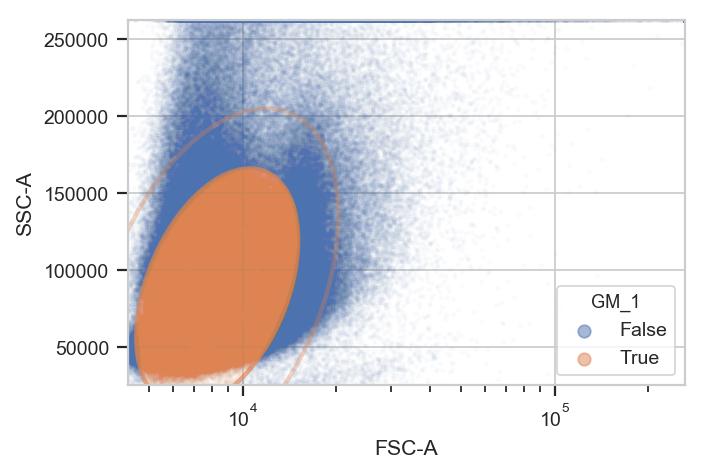

In [16]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'linear'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


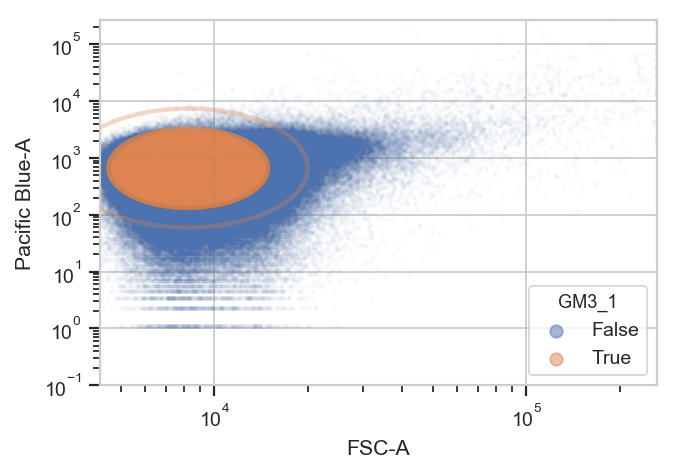

In [17]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [18]:
df =ex_gm2.data

# filter out events that don't fall within the gates

In [19]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,IPTG,Pacific Blue-A,Pacific Blue-H,Pacific Blue-W,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
2,1.000000e-12,859.739990,3046.0,18497.677734,8965.839844,8226.0,71430.257812,0.000,1905.119995,1316.0,94873.828125,120667.976562,118018.0,67007.546875,51.200001,True,True,True
4,1.000000e-12,2329.129883,1964.0,77719.890625,8680.940430,9216.0,61731.132812,0.000,601.440002,687.0,57374.054688,70164.929688,70087.0,65608.875000,51.299999,True,True,True
5,1.000000e-12,1731.049927,2616.0,43366.242188,4962.439941,5276.0,61641.105469,0.000,843.359985,910.0,60736.746094,89429.867188,88664.0,66102.085938,51.299999,True,True,True
6,1.000000e-12,7249.049805,8392.0,56610.316406,9104.219727,8844.0,67464.289062,0.000,925.119995,1406.0,43121.382812,137137.421875,134696.0,66723.875000,51.299999,True,True,True
7,1.000000e-12,541.119995,802.0,44218.007812,7027.040039,6390.0,72069.500000,0.000,751.520020,953.0,51680.609375,68569.156250,69282.0,64861.703125,51.400002,True,True,True
11,1.000000e-12,2454.619873,3913.0,41110.648438,6490.540039,6669.0,63782.281250,0.000,852.320007,887.0,62973.667969,91490.218750,89481.0,67007.554688,51.400002,True,True,True
12,1.000000e-12,5105.929688,4092.0,81774.734375,5806.040039,5464.0,69638.476562,0.000,1495.199951,1196.0,81930.960938,121243.804688,116904.0,67968.882812,51.400002,True,True,True
13,1.000000e-12,324.850006,928.0,22941.132812,6062.820312,6292.0,63148.917969,0.000,1049.440063,731.0,94084.960938,91531.156250,90864.0,66017.187500,51.500000,True,True,True
15,1.000000e-12,769.849976,1965.0,25675.769531,9905.639648,10345.0,62752.636719,0.000,805.280029,861.0,61294.812500,128808.804688,123689.0,68248.703125,51.500000,True,True,True
16,1.000000e-12,1689.219971,2273.0,48704.234375,6556.399902,7653.0,56145.332031,0.000,537.599976,339.0,103929.648438,65916.070312,65285.0,66169.492188,51.500000,True,True,True


In [20]:
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import numpy as np

def geom_sd(a):
    a = np.array(a)
    u = gmean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
    
    return np.exp(np.std(np.log(a)))
def geom_sem(a):
    a = np.array(a)
    u = geom_mean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
def geom_std(values):
    """
    Calculates the geometric standard deviation for the passed values.
    Source: https://en.wikipedia.org/wiki/Geometric_standard_deviation
    """

   # gmean = stats.gmean(values)
    return sp.exp(sp.sqrt(sp.sum([sp.log(x / gmean(values)) ** 2 for x in values]) / len(values))) 


# Plot mean FITC-A

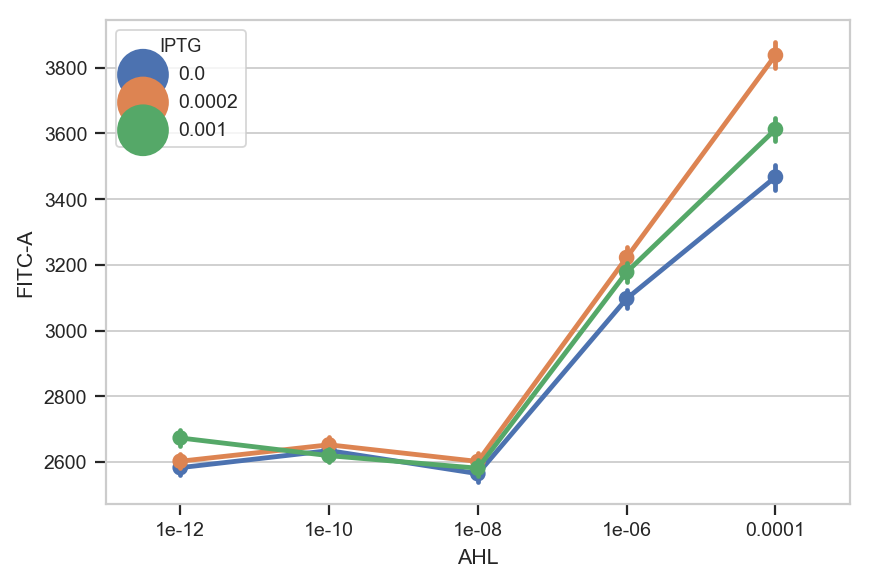

In [21]:
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=df)

In [22]:
gb = df.groupby(['AHL','IPTG'])
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
geostd = df.groupby(['AHL','IPTG'])['FITC-A'].apply(geom_sd).reset_index()

std = df.groupby(['AHL','IPTG'])['FITC-A'].std().reset_index()


# Plot Geometric mean FITC-A

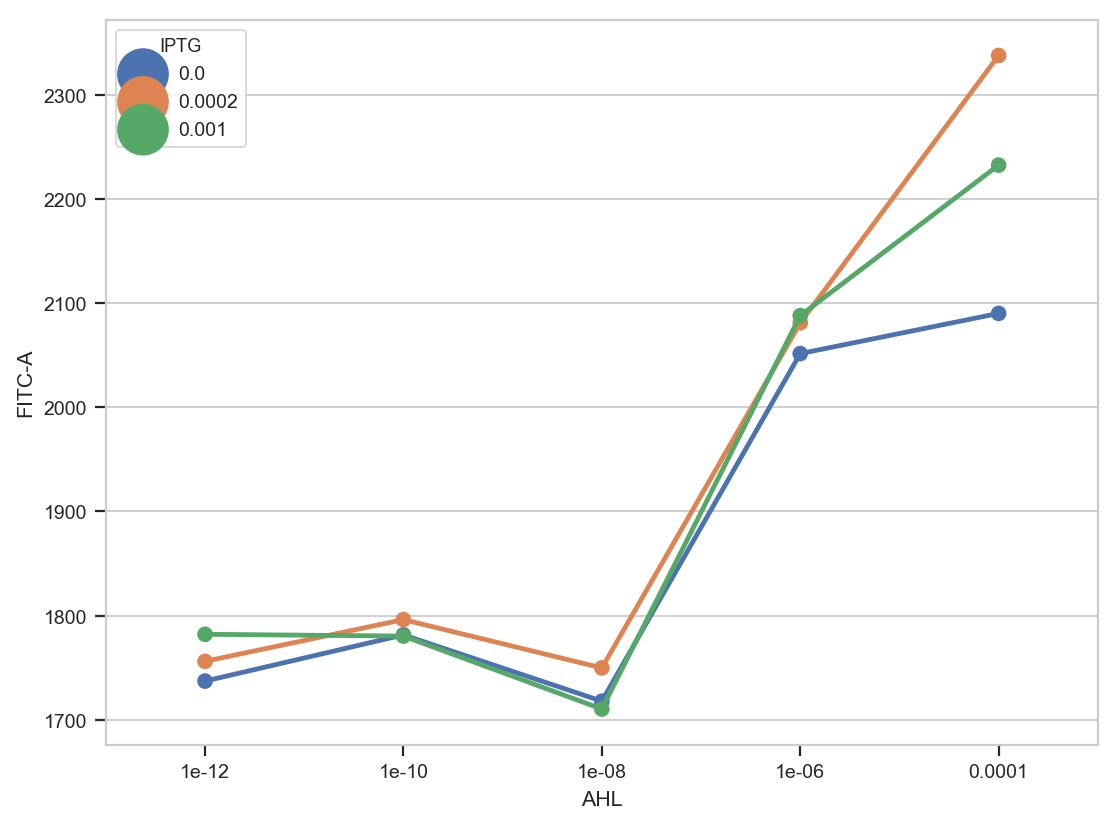

In [23]:
f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',estimator=gmean,ci=0.01,data=df)
f.savefig('Tra.png',dpi=600)

In [24]:
mean

,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,1737.154114
1,1.000000e-12,0.0002,1756.119965
2,1.000000e-12,0.0010,1782.088286
3,1.000000e-10,0.0000,1781.494882
4,1.000000e-10,0.0002,1796.174921
5,1.000000e-10,0.0010,1780.346950
6,1.000000e-08,0.0000,1717.859872
7,1.000000e-08,0.0002,1749.784752
8,1.000000e-08,0.0010,1710.338885
9,1.000000e-06,0.0000,2051.510654


# Calculate standard deviation percentages

In [25]:
std['FITC-A']/mean['FITC-A']*100

0     181.330210
1     178.119966
2     196.805374
3     186.700141
4     178.939580
5     168.140908
6     187.589231
7     197.965176
8     207.945908
9     180.863975
10    204.339539
11    199.154929
12    239.906372
13    240.161438
14    213.561880
Name: FITC-A, dtype: float64

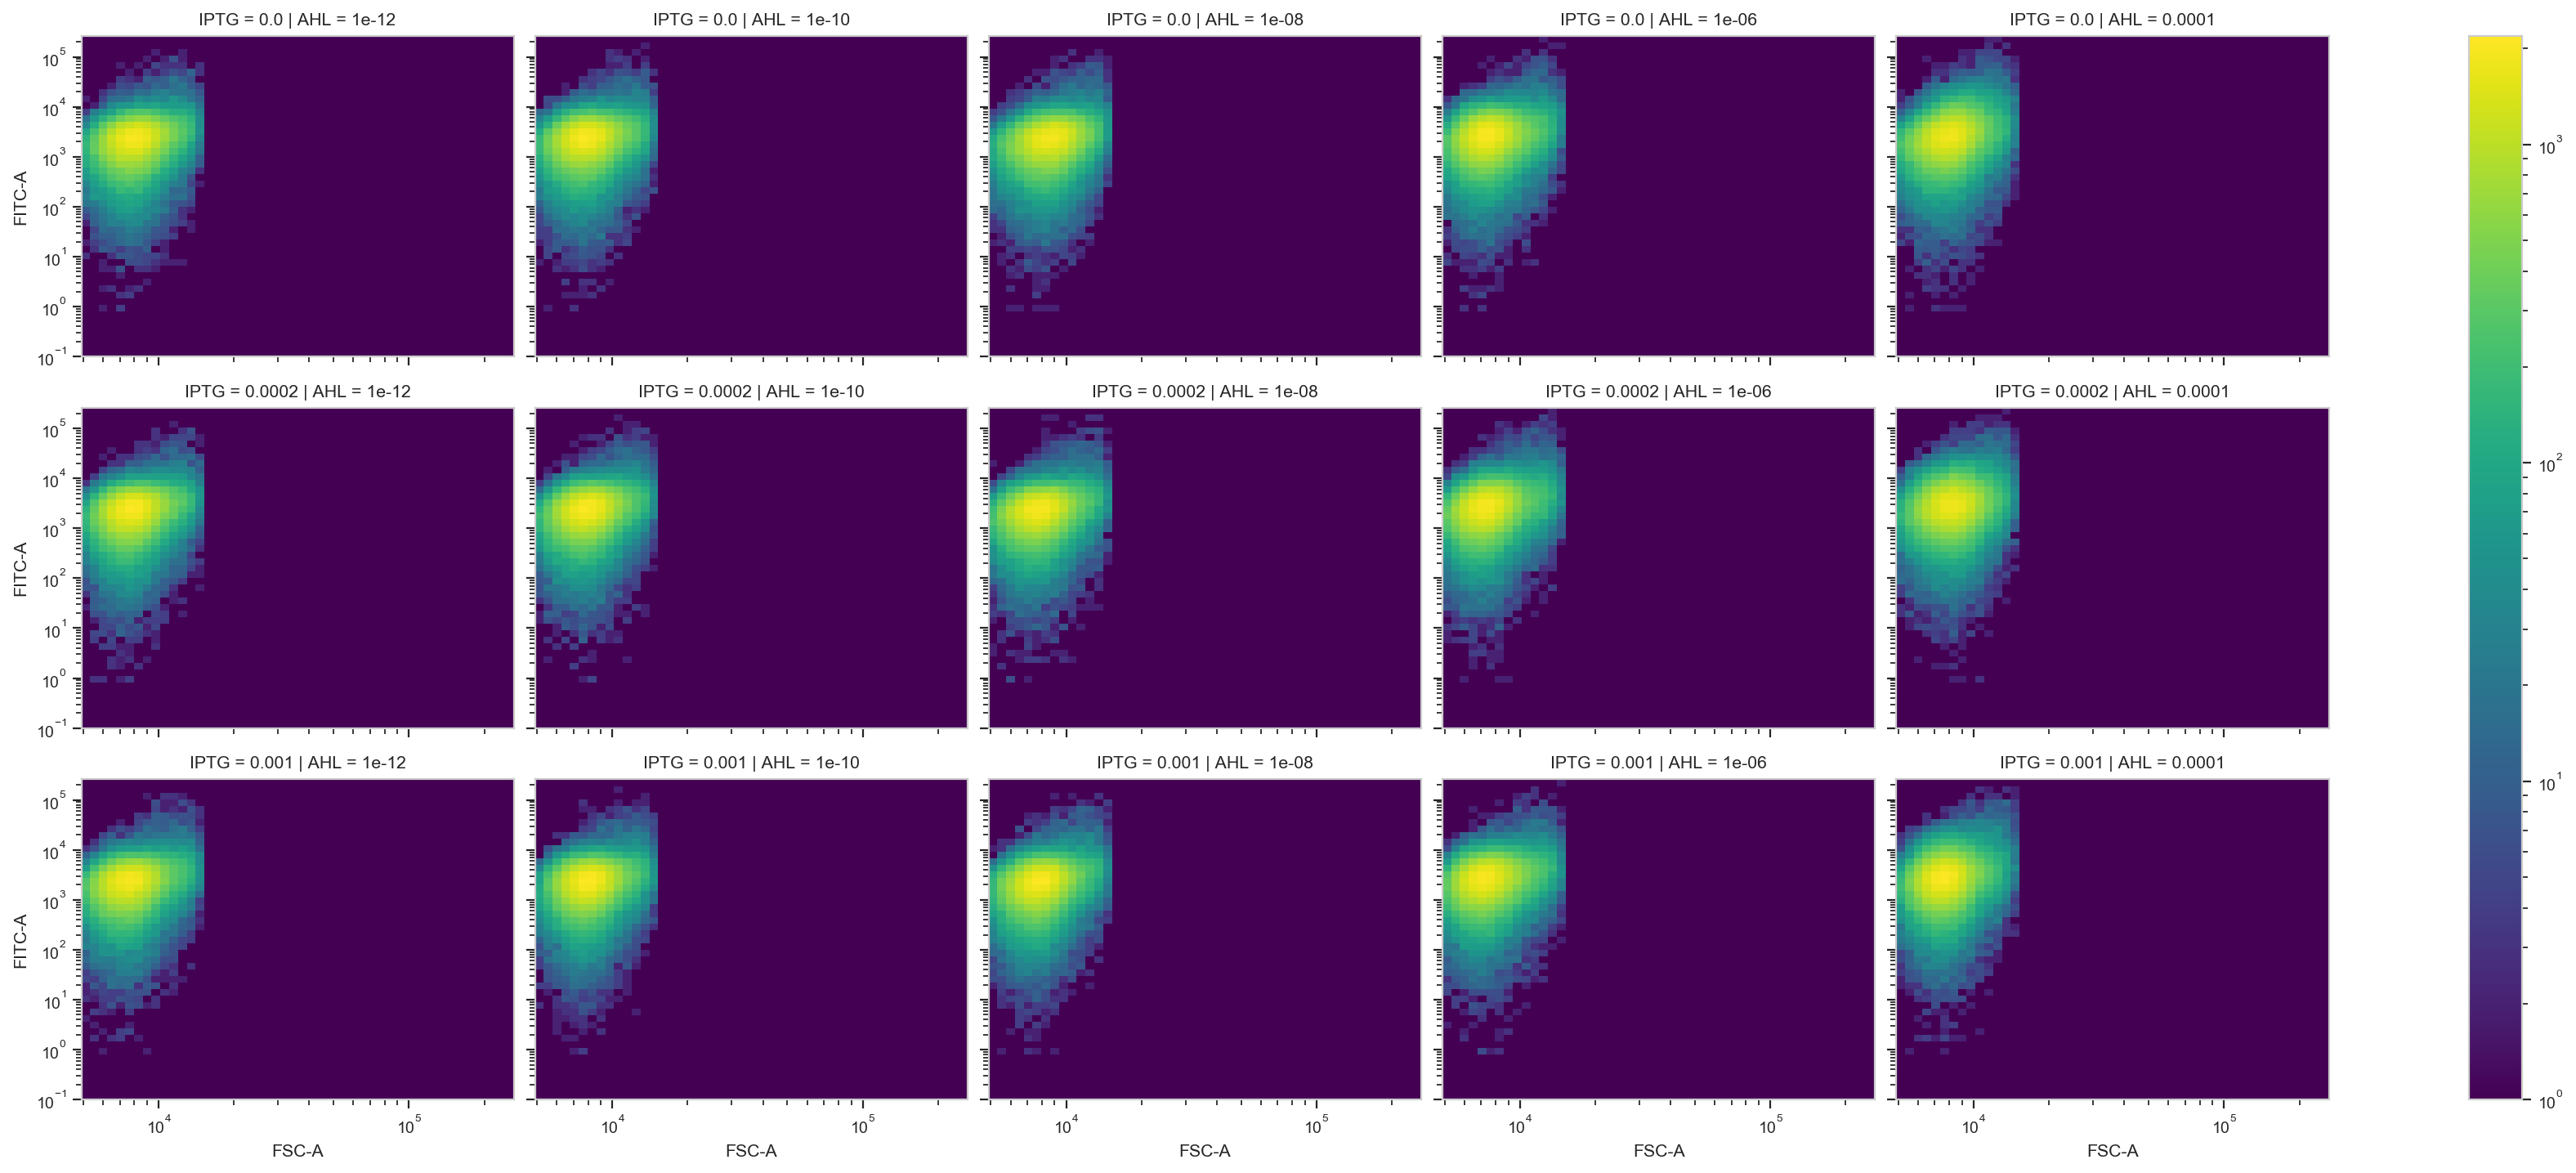

In [26]:

flow.DensityView(xchannel = 'FSC-A', 
                ychannel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'GM_1 == True').plot(ex_gm2, min_quantile = 0.01)

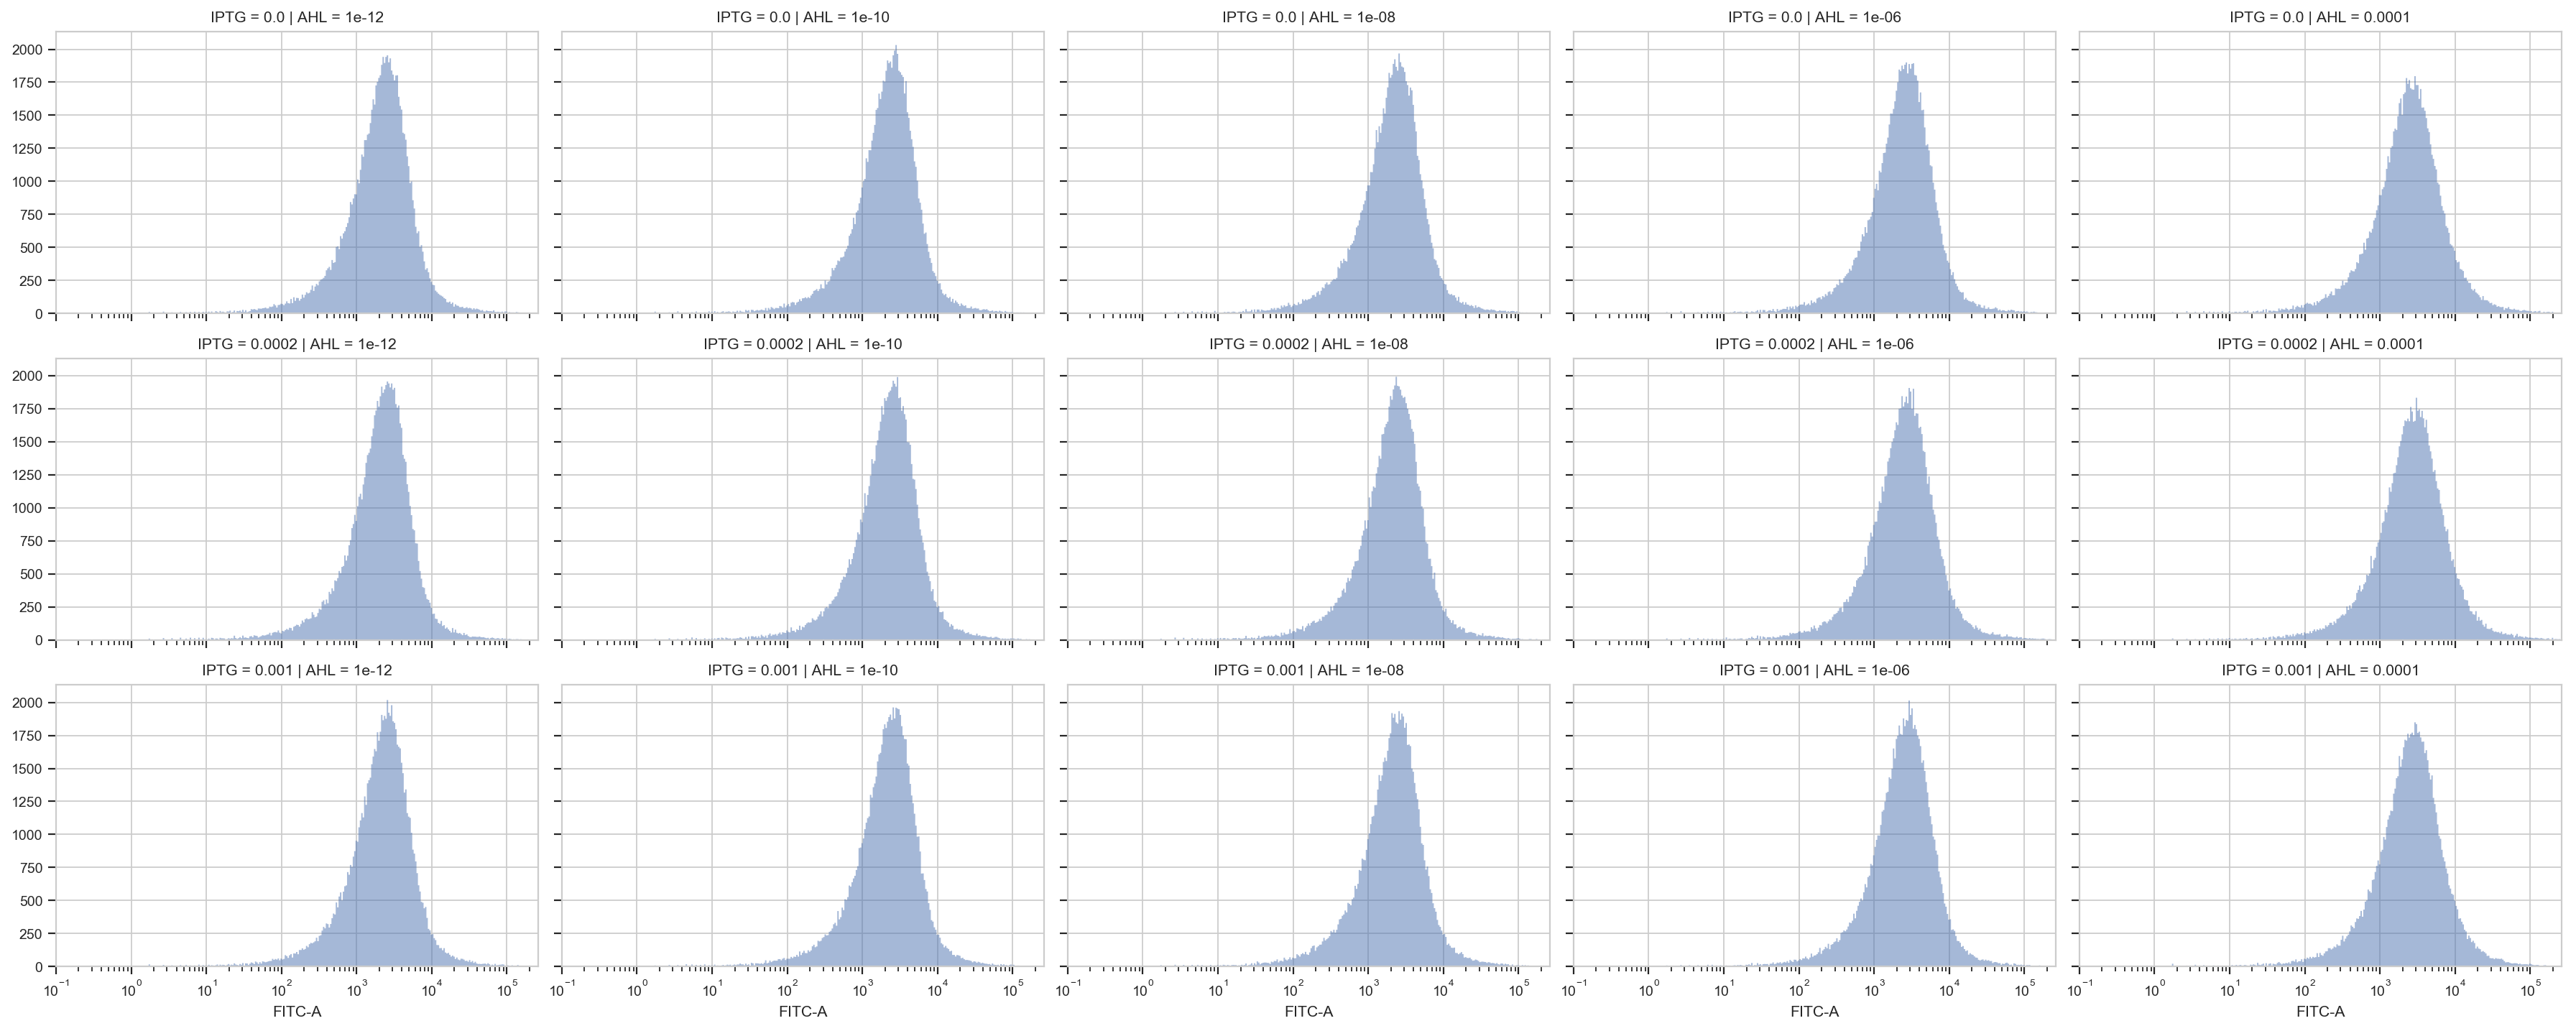

In [27]:
flow.HistogramView(channel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'Range2D == True').plot(ex_gm2, min_quantile = 0.01)

# Plot heatmaps showing absolute and relative induction

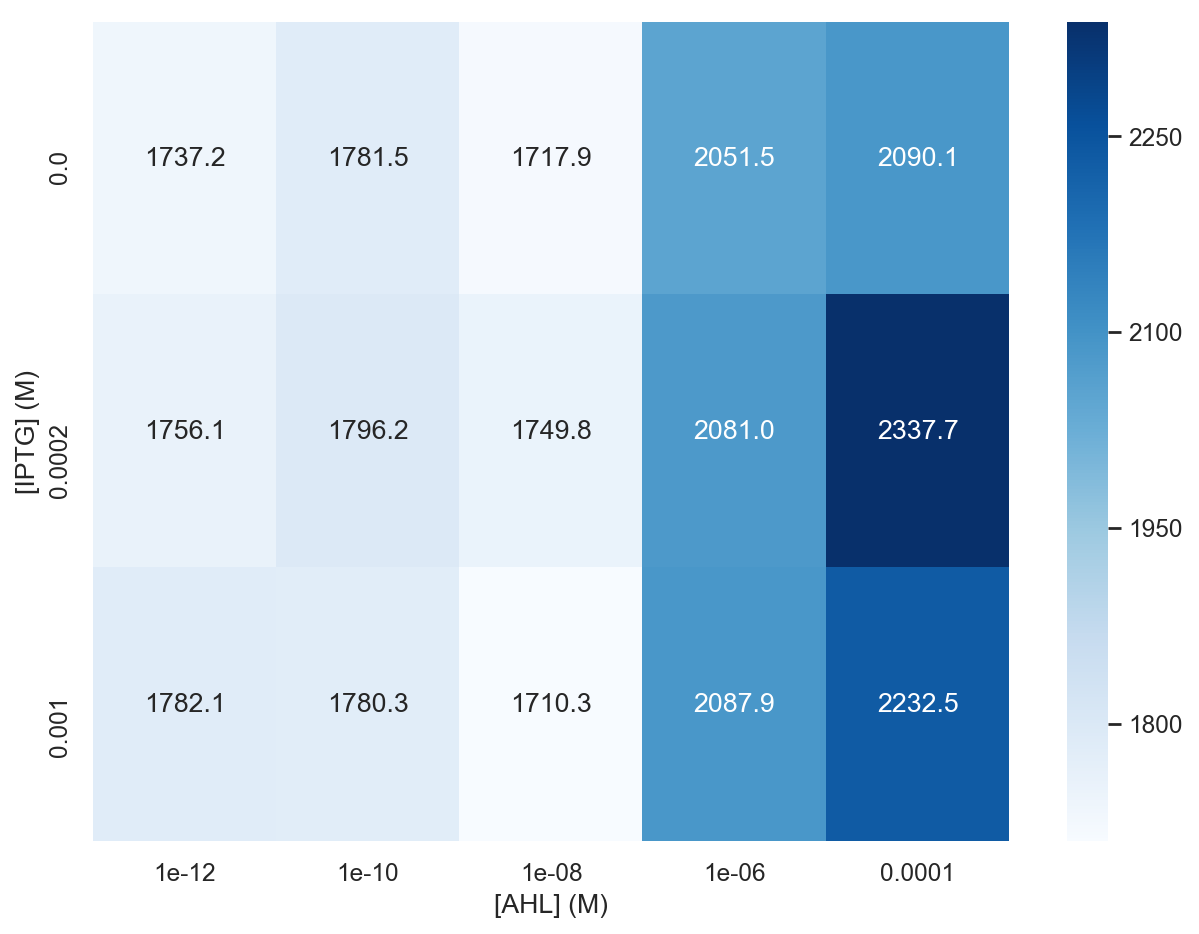

In [28]:
#LasMeans = Las.groupby(['C_ahl','C_iptg']).mean().reset_index()
sns.set(style="white")
#sns.set_style('Talk')
#LasTable = pd.pivot_table(LasMeans,values='FITC-A',index='C_iptg',columns='C_ahl')
f, ax = plt.subplots(figsize=(8,6))
#g = sns.heatmap(LasTable,vmin=0,vmax=100,xticklabels=[0,1e-10,1e-9,1e-7],yticklabels=[0,1e-3,1e-4,1e-5],ax=ax,square=True,cmap='Reds')



#f.savefig('LasHeatmap.png',dpi=600)
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
#mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

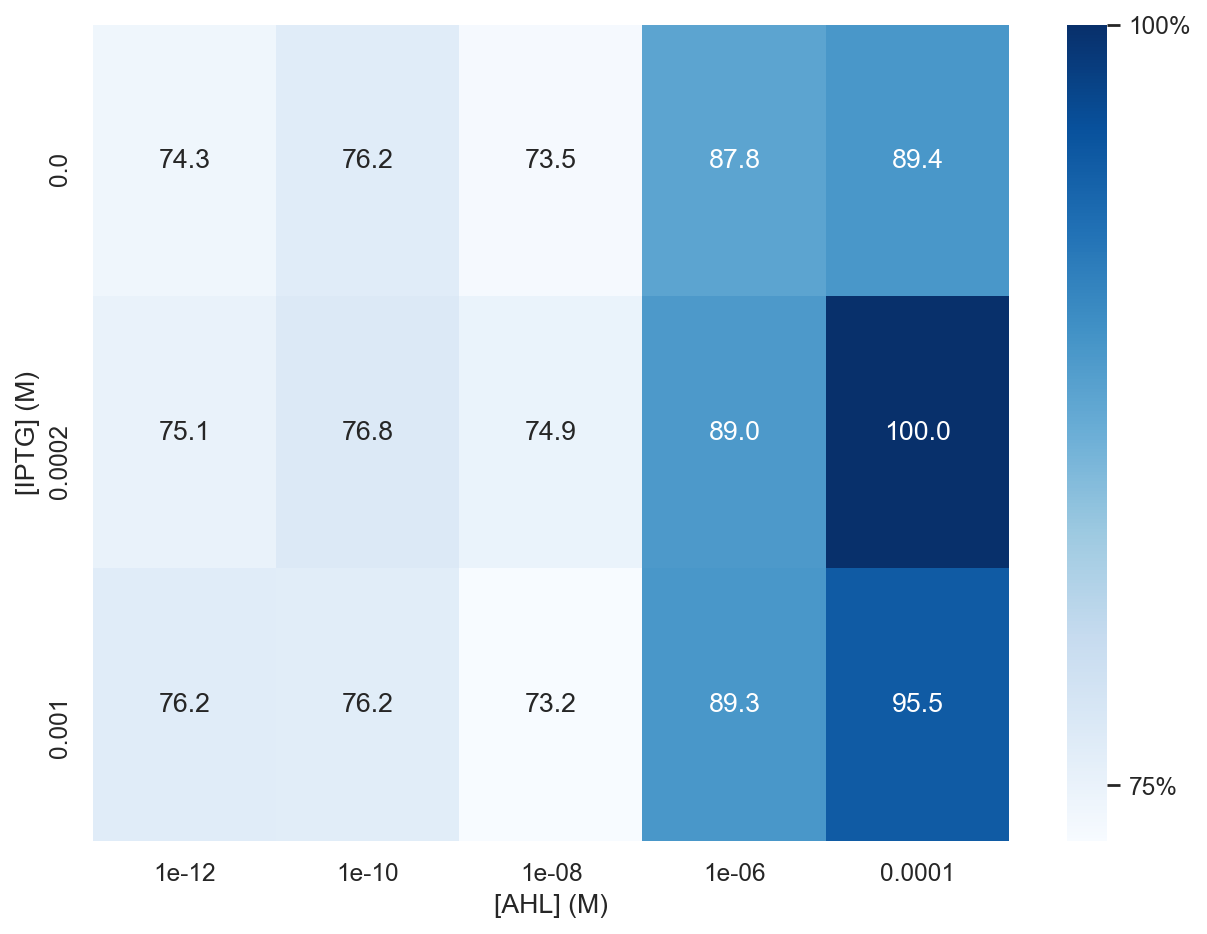

In [29]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [30]:

R =[]
for i in mean.IPTG.unique():
    tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [31]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.0000,1.216696
1,0.0002,1.335995
2,0.0010,1.305277


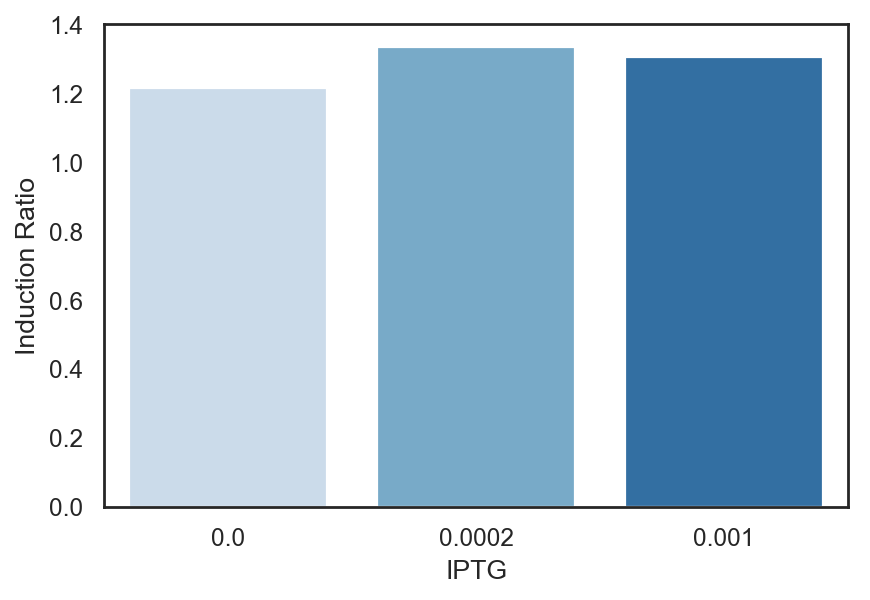

In [32]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

# Fit data to logistic function

In [33]:
import scipy.optimize as opt
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
data = mean.copy()
data.AHL[data.AHL == 0]=1e-14


In [34]:
data

,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,1737.154114
1,1.000000e-12,0.0002,1756.119965
2,1.000000e-12,0.0010,1782.088286
3,1.000000e-10,0.0000,1781.494882
4,1.000000e-10,0.0002,1796.174921
5,1.000000e-10,0.0010,1780.346950
6,1.000000e-08,0.0000,1717.859872
7,1.000000e-08,0.0002,1749.784752
8,1.000000e-08,0.0010,1710.338885
9,1.000000e-06,0.0000,2051.510654


C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated


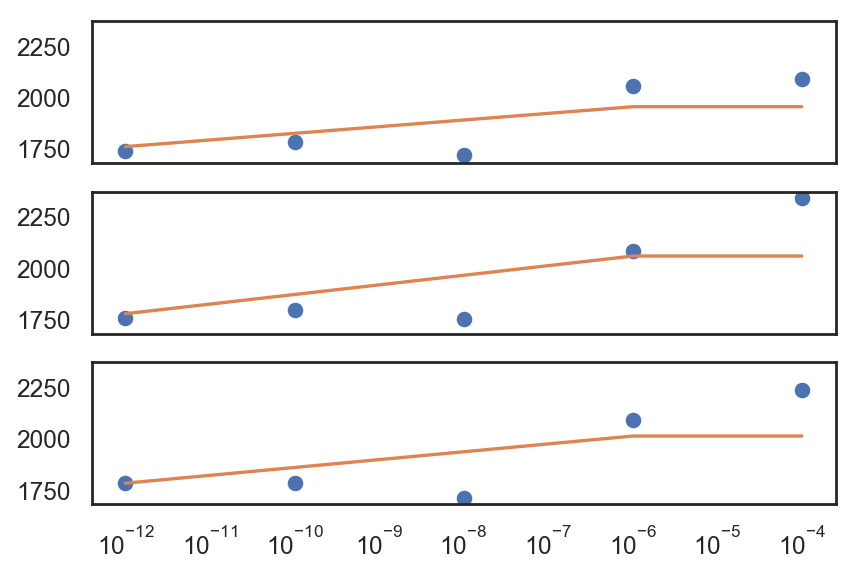

In [35]:
def f(x, a, b, c, d):
    return (a -b) / (1 + np.exp(c * (np.log10(d)-np.log10(x)))) + b
fig, axes = plt.subplots(3, 1, figsize=(6, 4),sharex=True,sharey=True)
axs = axes.ravel()
for i,iptg in enumerate(data.IPTG.unique()):
    tmp = data[data.IPTG==iptg]
    (a_, b_, c_, d_), _ = opt.curve_fit(f, tmp.AHL, tmp['FITC-A'],p0=[5e3,1e2,1e2,1e-9],maxfev=10000000)
    n = 100
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), n)

    y_fit = f(x, a_, b_, c_, d_)

    
    axs[i].plot(tmp.AHL.values, tmp['FITC-A'].values, 'o')
    axs[i].plot(x, y_fit, '-')
    plt.xscale('log')
plt.show()

In [36]:
tmp.AHL

2     1.000000e-12
5     1.000000e-10
8     1.000000e-08
11    1.000000e-06
14    1.000000e-04
Name: AHL, dtype: float64

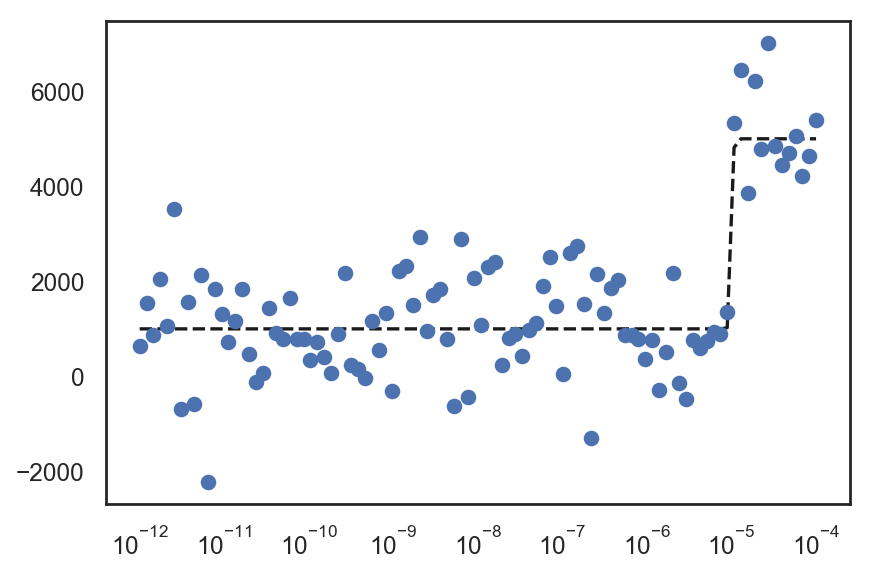

In [37]:
#a, c = np.random.exponential(size=2,scale=1e4)
#b, d = np.random.randn(2)
a,b,c,d = 5000,1000,1e2,1e-5
n = 100
#x = np.linspace(-12, -4, n)
x = np.logspace(-12,-4,n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)
#(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y,p0=[1e4,1,1,d])
#y_fit = f(x, a_, b_, c_, d_)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')
#ax.plot(x, y_fit, '-')
plt.xscale('log')



In [38]:
print(a_, b_, c_, d_)

2010.2408829589813 1781.2176180158474 100.0 1e-09


In [39]:
np.log10(0)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10


-inf

In [40]:
x

array([1.00000000e-12, 1.20450354e-12, 1.45082878e-12, 1.74752840e-12,
       2.10490414e-12, 2.53536449e-12, 3.05385551e-12, 3.67837977e-12,
       4.43062146e-12, 5.33669923e-12, 6.42807312e-12, 7.74263683e-12,
       9.32603347e-12, 1.12332403e-11, 1.35304777e-11, 1.62975083e-11,
       1.96304065e-11, 2.36448941e-11, 2.84803587e-11, 3.43046929e-11,
       4.13201240e-11, 4.97702356e-11, 5.99484250e-11, 7.22080902e-11,
       8.69749003e-11, 1.04761575e-10, 1.26185688e-10, 1.51991108e-10,
       1.83073828e-10, 2.20513074e-10, 2.65608778e-10, 3.19926714e-10,
       3.85352859e-10, 4.64158883e-10, 5.59081018e-10, 6.73415066e-10,
       8.11130831e-10, 9.77009957e-10, 1.17681195e-09, 1.41747416e-09,
       1.70735265e-09, 2.05651231e-09, 2.47707636e-09, 2.98364724e-09,
       3.59381366e-09, 4.32876128e-09, 5.21400829e-09, 6.28029144e-09,
       7.56463328e-09, 9.11162756e-09, 1.09749877e-08, 1.32194115e-08,
       1.59228279e-08, 1.91791026e-08, 2.31012970e-08, 2.78255940e-08,
      

In [41]:
data


,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,1737.154114
1,1.000000e-12,0.0002,1756.119965
2,1.000000e-12,0.0010,1782.088286
3,1.000000e-10,0.0000,1781.494882
4,1.000000e-10,0.0002,1796.174921
5,1.000000e-10,0.0010,1780.346950
6,1.000000e-08,0.0000,1717.859872
7,1.000000e-08,0.0002,1749.784752
8,1.000000e-08,0.0010,1710.338885
9,1.000000e-06,0.0000,2051.510654


In [42]:
df.AHL.unique()

array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])

In [43]:
df[df.AHL==1e-4]['FITC-A']

400003      1701.679932
400004      1391.959961
400005      7169.839844
400008       626.559998
400009      3783.389893
400011      2989.510010
400013      3675.699951
400015      7161.830078
400017       621.219971
400018      2063.909912
400020     38635.789062
400021      1630.479980
400022      3134.579834
400023      2791.040039
400024      5609.669922
400027       186.899994
400028      3447.859863
400029      1050.199951
400030      3907.989990
400031      5767.199707
400032       962.089966
400034      9700.109375
400035      6793.370117
400036      2071.030029
400037      4827.359863
400040      1003.029968
400041       354.220001
400043      4372.569824
400044      1600.219971
400046      1965.119995
               ...     
1499963     4858.509766
1499964      178.889999
1499966     2463.520020
1499967     7925.449707
1499968      938.950012
1499969     4652.919922
1499971     2455.510010
1499972     1313.640015
1499974     5439.679688
1499975     6950.009766
1499976     8434

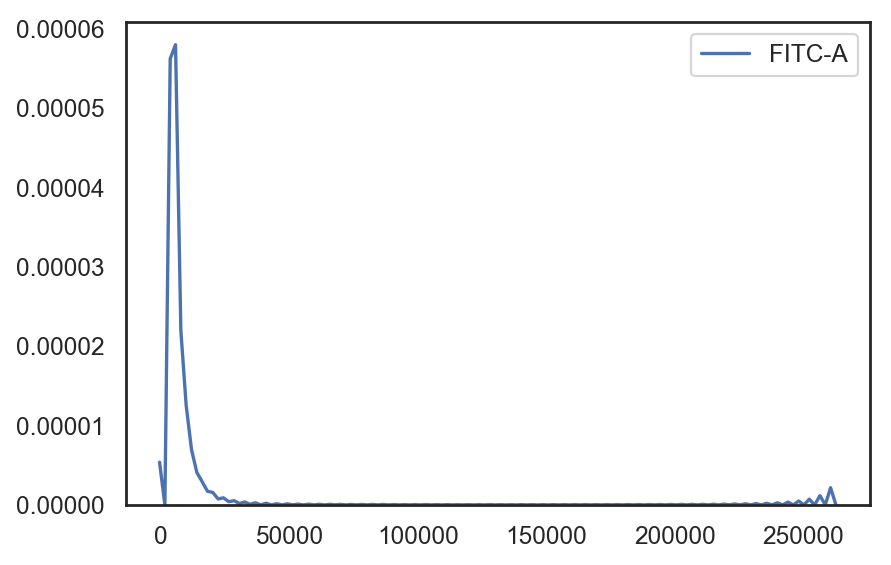

In [44]:
sns.kdeplot(df[df.AHL==1e-4]['FITC-A'])

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


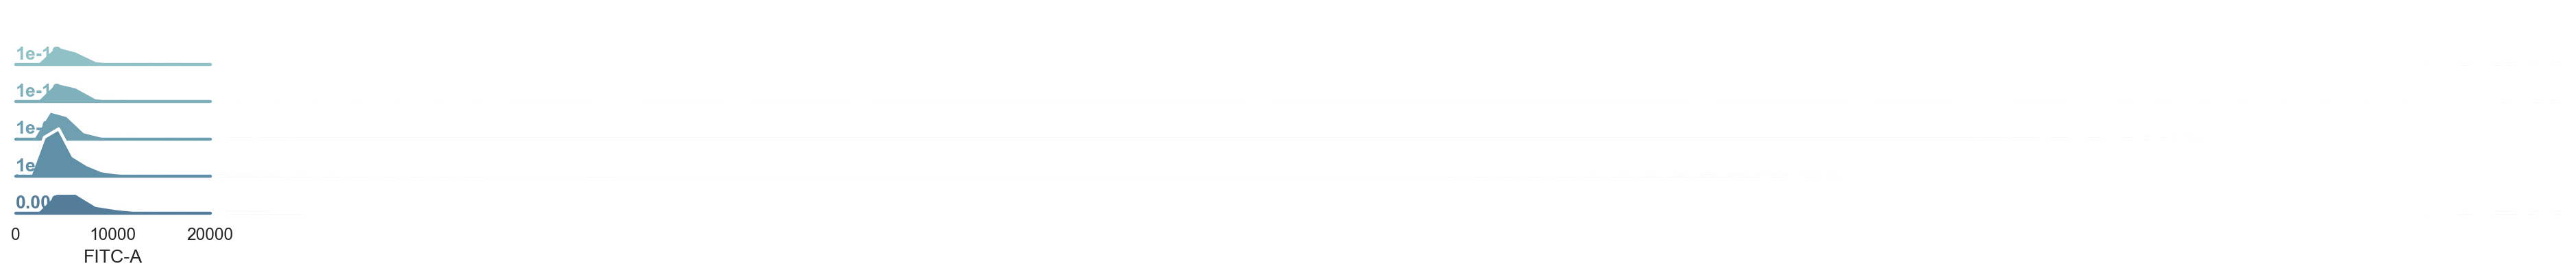

In [45]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
#rs = np.random.RandomState(1979)
#x = rs.randn(500)
#g = np.tile(list("ABCDEFGHIJ"), 50)
#df = pd.DataFrame(dict(x=x, g=g))
#m = df.g.map(ord)
#df["x"] += m
tmpdf = df[df.IPTG==0][['AHL','FITC-A']]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=5, height=0.5, palette=pal)
g.set(xlim=(0, 20000))
# Draw the densities in a few steps
g.map(sns.kdeplot, "FITC-A", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "FITC-A", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "FITC-A")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

